In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_curve, roc_curve, auc, confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve, auc
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve, auc


In [18]:
df = pd.read_csv('/kaggle/input/crime-data-from-2020-to-presen-csv/Crime_Data_from_2020_to_Presen.csv')

In [19]:
df.isnull().sum() * 100 / len(df)

DR_NO              0.000000
Date Rptd          0.000000
DATE OCC           0.000000
TIME OCC           0.000000
AREA               0.000000
AREA NAME          0.000000
Rpt Dist No        0.000000
Part 1-2           0.000000
Crm Cd             0.000000
Crm Cd Desc        0.000000
Mocodes           14.578269
Vict Age           0.000000
Vict Sex          13.887264
Vict Descent      13.888294
Premis Cd          0.001442
Premis Desc        0.060056
Weapon Used Cd    66.458548
Weapon Desc       66.458548
Status             0.000103
Status Desc        0.000000
Crm Cd 1           0.001133
Crm Cd 2          92.921216
Crm Cd 3          99.762660
Crm Cd 4          99.993407
LOCATION           0.000000
Cross Street      84.482673
LAT                0.000000
LON                0.000000
dtype: float64

In [20]:
#drop rows with empty weapon used cd
df = df.dropna(subset=['Weapon Used Cd'])

In [21]:
#in the columns Date Rptd, DATE OCC keep only the first 10 charecters of each value and remove the rest
df['Date Rptd'] = df['Date Rptd'].str[:10]
df['DATE OCC'] = df['DATE OCC'].str[:10]

In [22]:
#in the columns Date Rptd, DATE OCC replace 3rd and 6th charecters with /
df['Date Rptd'] = df['Date Rptd'].str.replace('/', '-')
df['DATE OCC'] = df['DATE OCC'].str.replace('/', '-')

In [23]:
#set Date Rptd and DATE OCC to datetime
df['Date Rptd'] = pd.to_datetime(df['Date Rptd'])
df['DATE OCC'] = pd.to_datetime(df['DATE OCC'])

In [24]:
#crm cd is categorical
df['Crm Cd'] = df['Crm Cd'].astype('category')

In [25]:
#in TIME OCC use zfill to add 2 zeros at the beginning
df['TIME OCC'] = df['TIME OCC'].apply(lambda x: str(x).zfill(4))

In [26]:
#circular encode TIME OCC
df['TIME OCC'] = df['TIME OCC'].apply(lambda x: int(x) % 2400)

In [27]:
#target encode Vict Descent
# Calculate the mean of the target for each Vict Descent category
target_mean = df.groupby('Vict Descent')['Vict Age'].mean()

# Map each Vict Descent to its corresponding target mean
df['Vict Descent'] = df['Vict Descent'].map(target_mean)

# Calculate the global mean of the target
global_mean = df['Vict Age'].mean()

# Fill missing values in the encoded column with the global mean
df['Vict Descent'] = df['Vict Descent'].fillna(global_mean)

In [28]:
#frequency encoding premis cd
df['Premis Cd'] = df['Premis Cd'].map(df['Premis Cd'].value_counts())

In [29]:
#unique status
df['Status'].unique()

array(['IC', 'AA', 'AO', 'JA', 'JO', 'CC'], dtype=object)

<Axes: xlabel='Crm Cd Desc'>

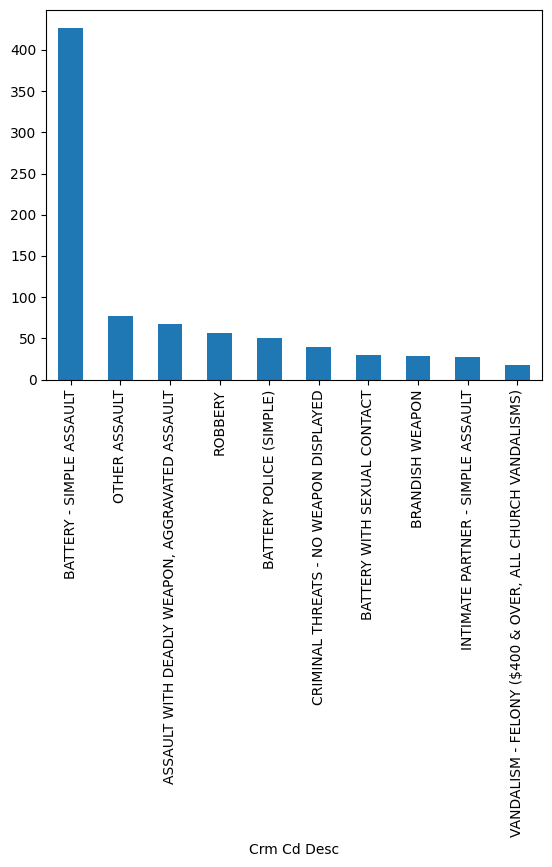

In [30]:
#TOP 10 CRIMES COMMITED IN 800 N ALAMEDA
df[df['LOCATION'] == '800 N  ALAMEDA                      ST']['Crm Cd Desc'].value_counts().head(10).plot(kind='bar')


<Axes: xlabel='Crm Cd Desc'>

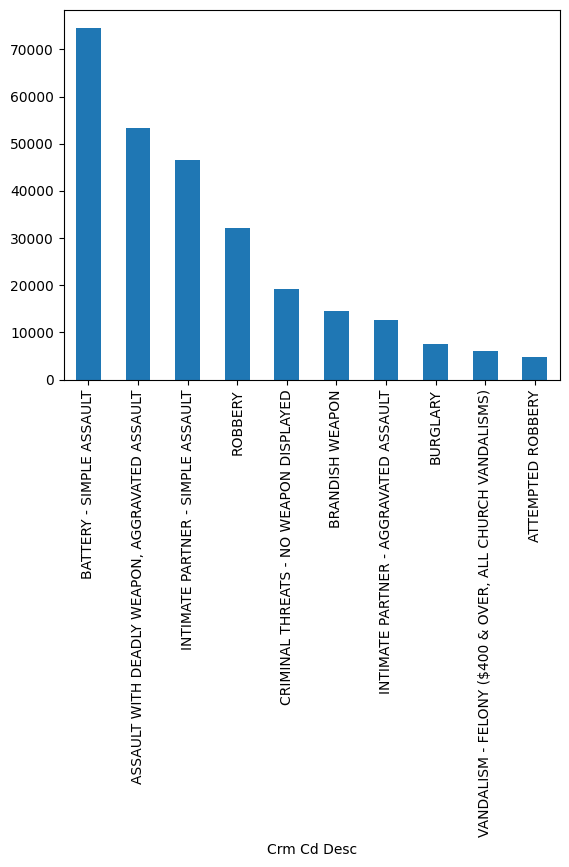

In [31]:
df['Crm Cd Desc'].value_counts().head(10).plot(kind='bar')


<Axes: xlabel='AREA NAME'>

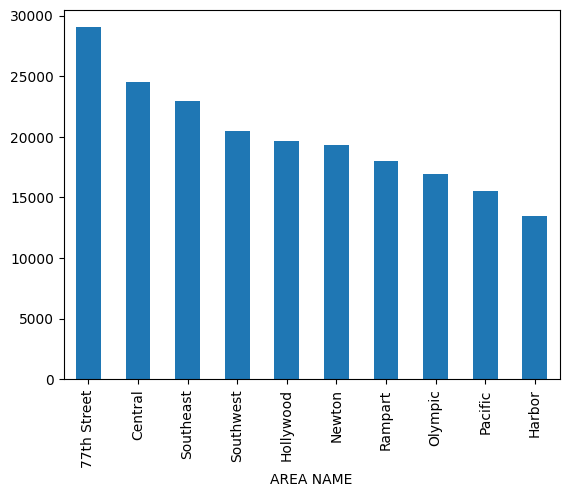

In [32]:
#areas with highest crime
df['AREA NAME'].value_counts().head(10).plot(kind='bar')


<Axes: >

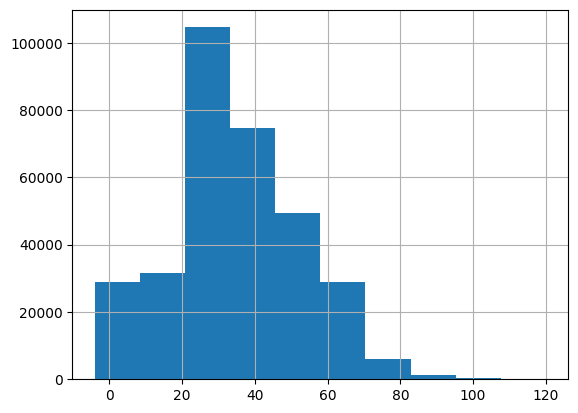

In [33]:
#victim age distribution
df['Vict Age'].hist()


<Axes: xlabel='Crm Cd Desc'>

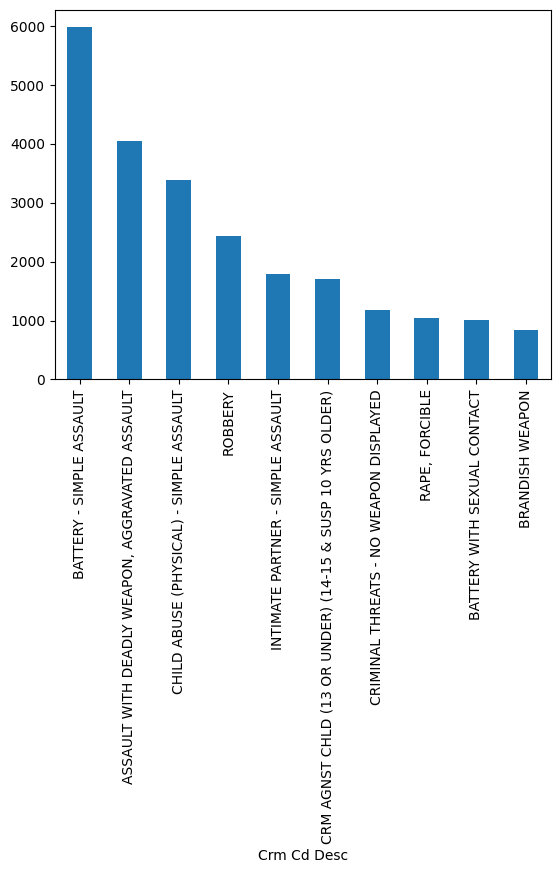

In [34]:
    #victim age 0-20 highest crime
df[(df['Vict Age'] >= 1) & (df['Vict Age'] < 20)]['Crm Cd Desc'].value_counts().head(10).plot(kind='bar')


<Axes: xlabel='Crm Cd Desc'>

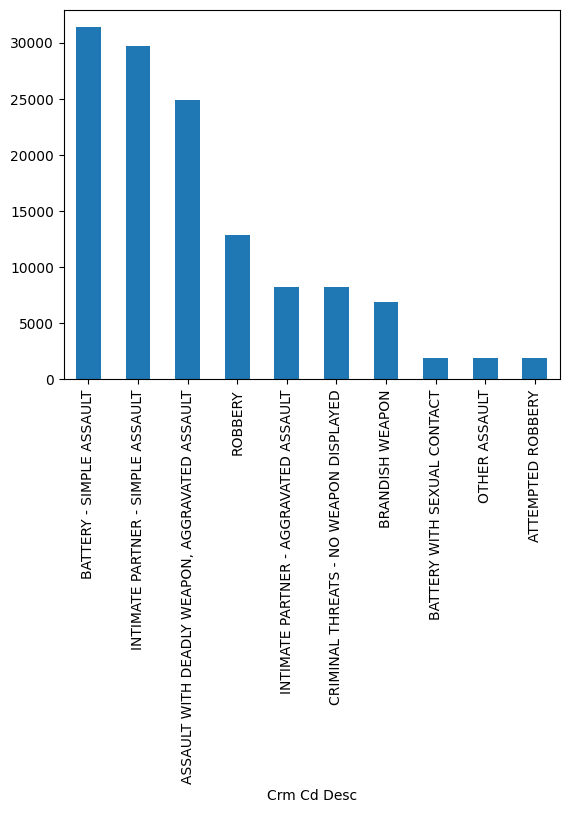

In [35]:
#victim age 21-40 highest crime
df[(df['Vict Age'] >= 21) & (df['Vict Age'] < 40)]['Crm Cd Desc'].value_counts().head(10).plot(kind='bar')


<Axes: xlabel='Crm Cd Desc'>

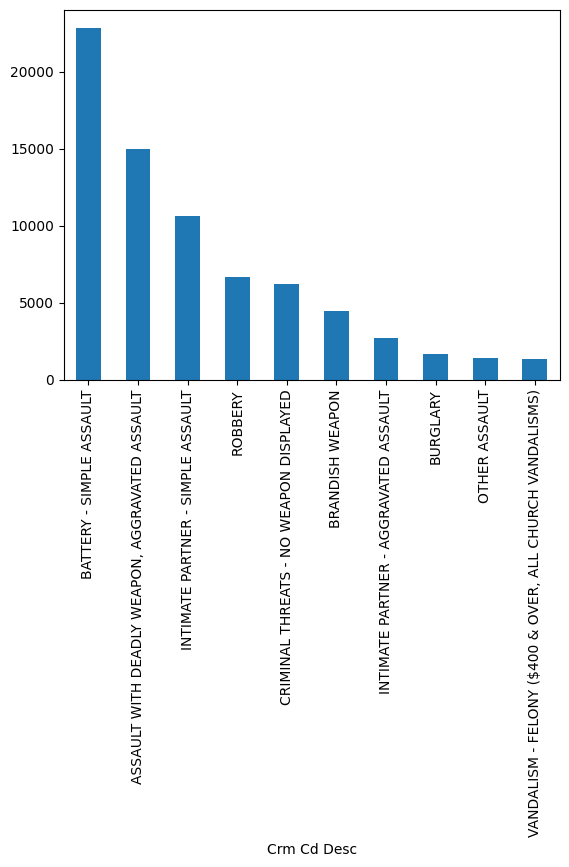

In [36]:
#victim age 41-60 highest crime
df[(df['Vict Age'] >= 41) & (df['Vict Age'] < 60)]['Crm Cd Desc'].value_counts().head(10).plot(kind='bar')


<Axes: xlabel='Crm Cd Desc'>

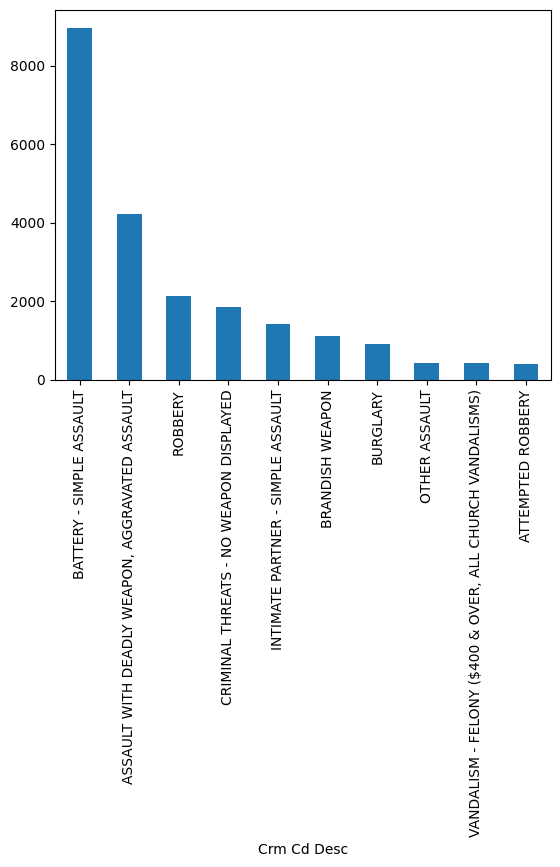

In [37]:
#victim age 61-80 highest crime
df[(df['Vict Age'] >= 61) & (df['Vict Age'] < 80)]['Crm Cd Desc'].value_counts().head(10).plot(kind='bar')


<Axes: xlabel='Crm Cd Desc'>

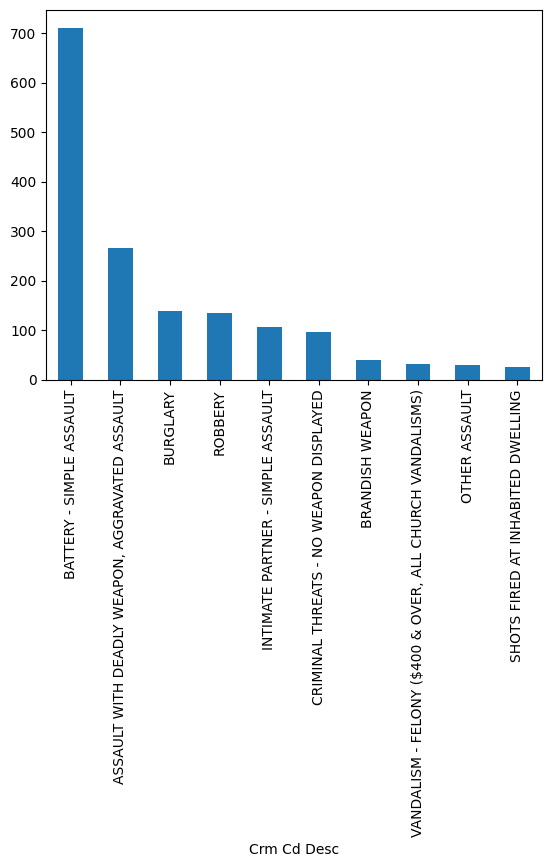

In [38]:
#victim age 81-100 highest crime
df[(df['Vict Age'] >= 81)]['Crm Cd Desc'].value_counts().head(10).plot(kind='bar')


Vict Sex                                                  F    H        M  \
Crm Cd Desc                                                                 
ARSON                                                 165.0  0.0    316.0   
ASSAULT WITH DEADLY WEAPON ON POLICE OFFICER           67.0  1.0    634.0   
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT      14280.0  6.0  38033.0   
ATTEMPTED ROBBERY                                    1218.0  1.0   3100.0   
BATTERY - SIMPLE ASSAULT                            35030.0  7.0  39133.0   
...                                                     ...  ...      ...   
VEHICLE, STOLEN - OTHER (MOTORIZED SCOOTERS, BI...      4.0  0.0      6.0   
VIOLATION OF COURT ORDER                              185.0  0.0     92.0   
VIOLATION OF RESTRAINING ORDER                        452.0  0.0    159.0   
VIOLATION OF TEMPORARY RESTRAINING ORDER               31.0  0.0     10.0   
WEAPONS POSSESSION/BOMBING                              4.0  0.0     14.0   

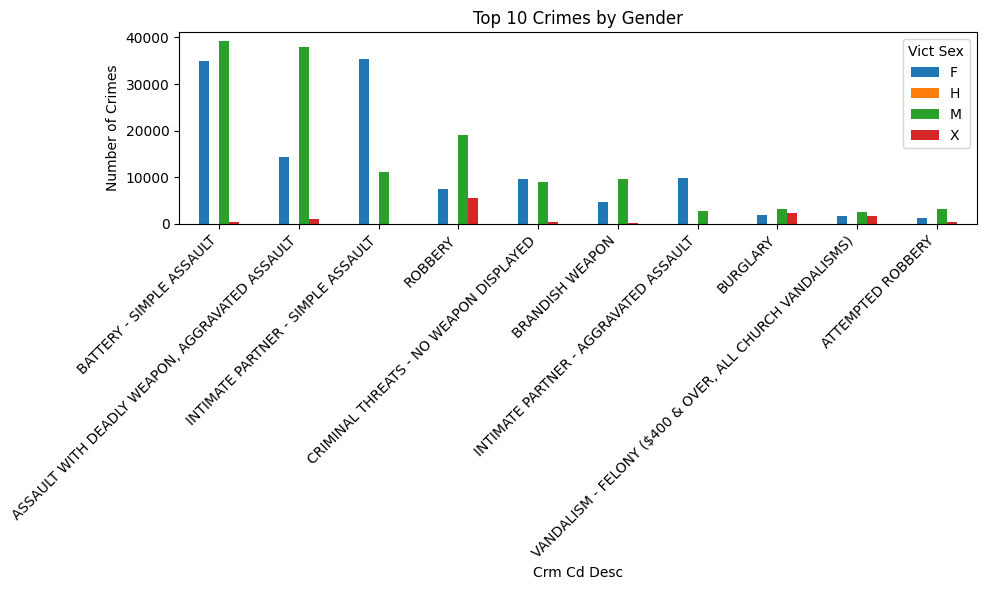

In [ ]:
#Is there a significant difference in the types of crimes experienced by men and women?

# Group data by 'Vict Sex' and 'Crm Cd Desc' to count the number of each crime type by gender
crime_by_gender = df.groupby(['Vict Sex', 'Crm Cd Desc']).size().reset_index(name='Count')

# Pivot the data to have separate columns for male and female
pivot_table = crime_by_gender.pivot_table(index='Crm Cd Desc', columns='Vict Sex', values='Count', fill_value=0)

# Display the pivot table
print(pivot_table)


# Plotting to visualize the differences

# Create a bar plot for the top 10 crimes for men and women
top_crimes = pivot_table.sum(axis=1).sort_values(ascending=False).head(10).index

pivot_table.loc[top_crimes].plot(kind='bar', figsize=(10,6))
plt.title('Top 10 Crimes by Gender')
plt.ylabel('Number of Crimes')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

Vict Sex                                              F    H        M       X  \
Crm Cd Desc                                                                     
INTIMATE PARTNER - SIMPLE ASSAULT               35396.0  3.0  11082.0    87.0   
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT  14280.0  6.0  38033.0   999.0   
ROBBERY                                          7558.0  3.0  18996.0  5539.0   
INTIMATE PARTNER - AGGRAVATED ASSAULT            9796.0  2.0   2837.0    13.0   
BRANDISH WEAPON                                  4784.0  0.0   9553.0   164.0   
BATTERY - SIMPLE ASSAULT                        35030.0  7.0  39133.0   452.0   
RAPE, FORCIBLE                                   3687.0  0.0     32.0     2.0   
BATTERY WITH SEXUAL CONTACT                      3736.0  0.0    374.0    20.0   
ATTEMPTED ROBBERY                                1218.0  1.0   3100.0   500.0   
BURGLARY                                         1953.0  0.0   3224.0  2423.0   

Vict Sex                   

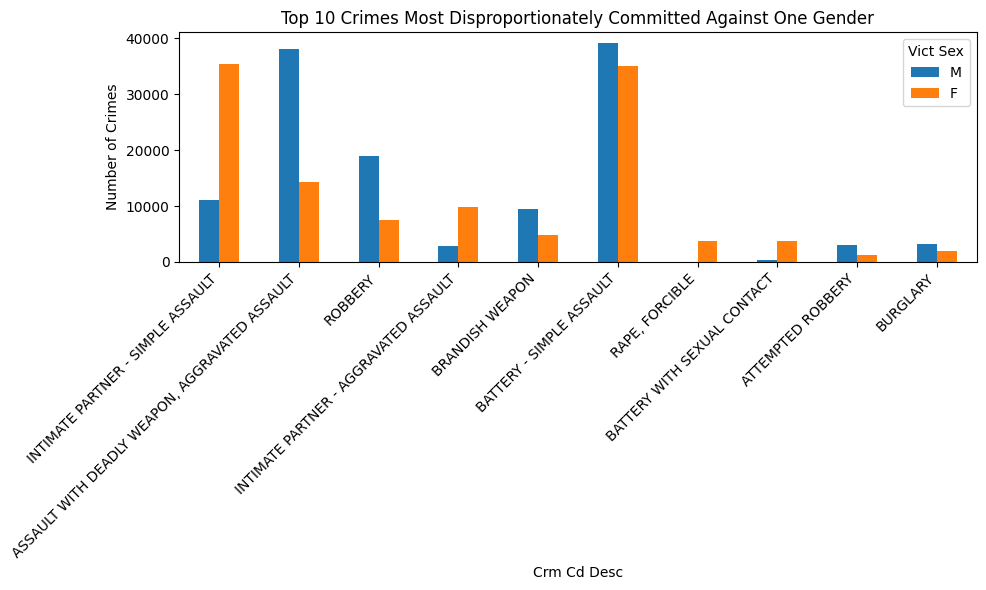

In [40]:
# Create a new column for the difference between the counts for males and females
# "M" for male and "F" for female
if 'M' in pivot_table.columns and 'F' in pivot_table.columns:
    pivot_table['Difference'] = np.abs(pivot_table['M'] - pivot_table['F'])
else:
    print("Ensure the 'M' and 'F' columns exist in the data.")

# Sort by the difference to see the most gender-skewed crimes
most_gender_skewed = pivot_table.sort_values(by='Difference', ascending=False).head(10)

# Display the most gender-skewed crimes
print(most_gender_skewed)

# Plot the most gender-skewed crimes
most_gender_skewed[['M', 'F']].plot(kind='bar', figsize=(10,6))
plt.title('Top 10 Crimes Most Disproportionately Committed Against One Gender')
plt.ylabel('Number of Crimes')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [41]:
#create new column year from date occ
df['Year'] = pd.DatetimeIndex(df['DATE OCC']).year

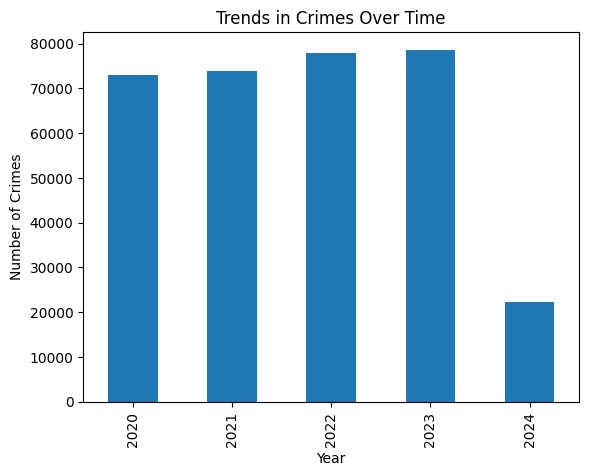

In [42]:
# trends in crime over time
df.groupby('Year').size().plot(kind='bar')
plt.title('Trends in Crimes Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Crimes')
plt.show()

Text(0.5, 1.0, 'BURGLARY')

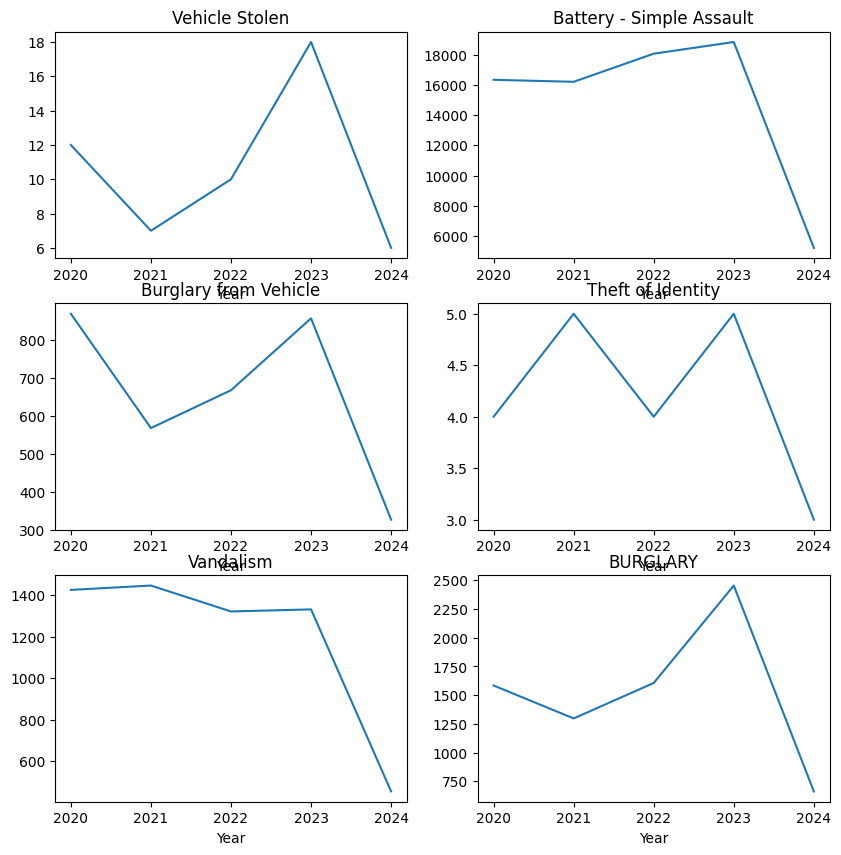

In [43]:
#yearly trends of vehicle stolen, battery- simple assault, burglary from vehicle, theft of identity, vandalism, burglary in 3x2 graph

fig, axs = plt.subplots(3, 2, figsize=(10, 10))

df[df['Crm Cd Desc'] == 'VEHICLE - STOLEN'].groupby('Year').size().plot(ax=axs[0, 0])
axs[0, 0].set_title('Vehicle Stolen')

df[df['Crm Cd Desc'] == 'BATTERY - SIMPLE ASSAULT'].groupby('Year').size().plot(ax=axs[0, 1])
axs[0, 1].set_title('Battery - Simple Assault')

df[df['Crm Cd Desc'] == 'BURGLARY FROM VEHICLE'].groupby('Year').size().plot(ax=axs[1, 0])
axs[1, 0].set_title('Burglary from Vehicle')

df[df['Crm Cd Desc'] == 'THEFT OF IDENTITY'].groupby('Year').size().plot(ax=axs[1, 1])
axs[1, 1].set_title('Theft of Identity')

df[df['Crm Cd Desc'] == 'VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)'].groupby('Year').size().plot(ax=axs[2, 0])
axs[2, 0].set_title('Vandalism')

df[df['Crm Cd Desc'] == 'BURGLARY'].groupby('Year').size().plot(ax=axs[2, 1])
axs[2, 1].set_title('BURGLARY')



In [44]:
# new column month from date occ
df['Month'] = pd.DatetimeIndex(df['DATE OCC']).month

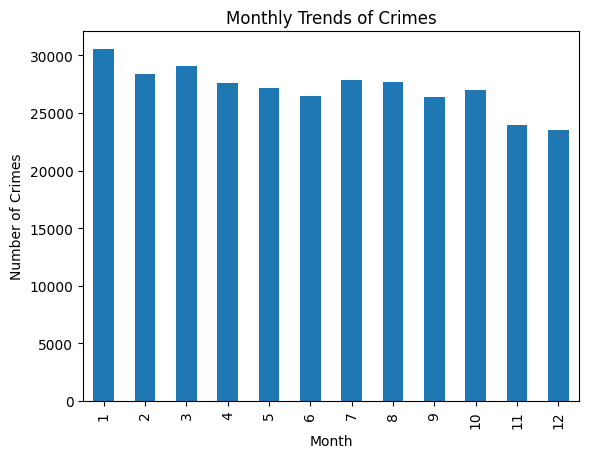

In [45]:
# monthly trends of crimes
df.groupby('Month').size().plot(kind='bar')
plt.title('Monthly Trends of Crimes')
plt.xlabel('Month')
plt.ylabel('Number of Crimes')
plt.show()

Text(0.5, 1.0, 'BURGLARY')

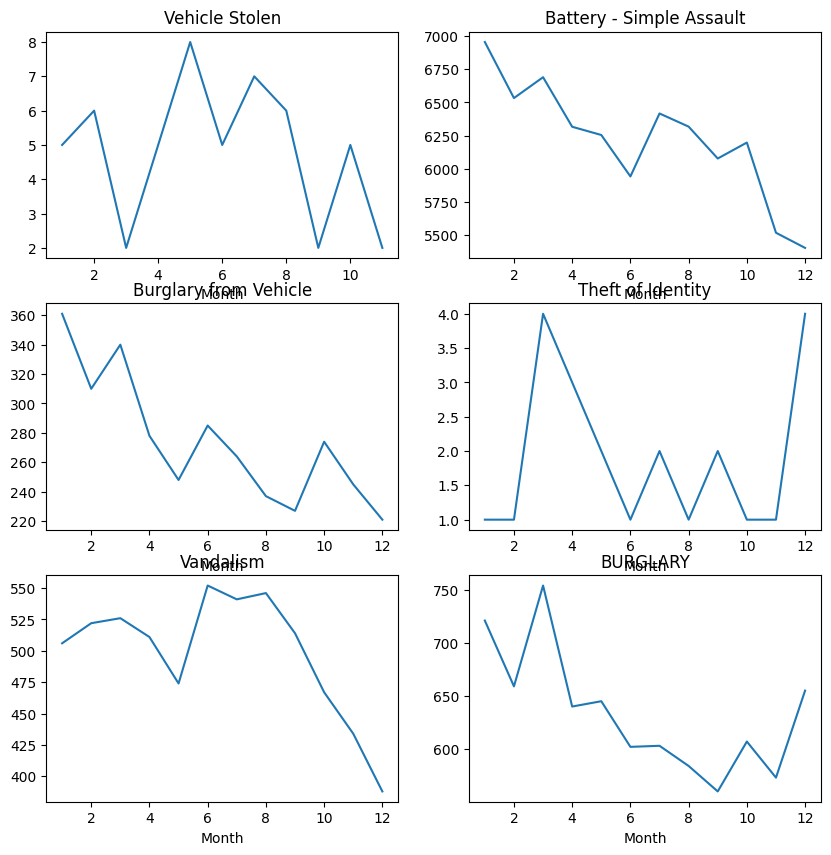

In [46]:
# monthly trends of vehicle stolen, battery- simple assault, burglary from vehicle, theft of identity, vandalism, burglary in 3x2 graph

fig, axs = plt.subplots(3, 2, figsize=(10, 10))

df[df['Crm Cd Desc'] == 'VEHICLE - STOLEN'].groupby('Month').size().plot(ax=axs[0, 0])
axs[0, 0].set_title('Vehicle Stolen')

df[df['Crm Cd Desc'] == 'BATTERY - SIMPLE ASSAULT'].groupby('Month').size().plot(ax=axs[0, 1])
axs[0, 1].set_title('Battery - Simple Assault')

df[df['Crm Cd Desc'] == 'BURGLARY FROM VEHICLE'].groupby('Month').size().plot(ax=axs[1, 0])
axs[1, 0].set_title('Burglary from Vehicle')

df[df['Crm Cd Desc'] == 'THEFT OF IDENTITY'].groupby('Month').size().plot(ax=axs[1, 1])
axs[1, 1].set_title('Theft of Identity')

df[df['Crm Cd Desc'] == 'VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)'].groupby('Month').size().plot(ax=axs[2, 0])
axs[2, 0].set_title('Vandalism')

df[df['Crm Cd Desc'] == 'BURGLARY'].groupby('Month').size().plot(ax=axs[2, 1])
axs[2, 1].set_title('BURGLARY')



In [47]:
#column names in df

df.columns

Index(['DR_NO', 'Date Rptd', 'DATE OCC', 'TIME OCC', 'AREA', 'AREA NAME',
       'Rpt Dist No', 'Part 1-2', 'Crm Cd', 'Crm Cd Desc', 'Mocodes',
       'Vict Age', 'Vict Sex', 'Vict Descent', 'Premis Cd', 'Premis Desc',
       'Weapon Used Cd', 'Weapon Desc', 'Status', 'Status Desc', 'Crm Cd 1',
       'Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4', 'LOCATION', 'Cross Street', 'LAT',
       'LON', 'Year', 'Month'],
      dtype='object')

In [48]:
# columns with null values greater than 0

df.isnull().sum()[df.isnull().sum() > 0]

Mocodes            664
Vict Sex            77
Premis Desc        203
Crm Cd 1             3
Crm Cd 2        281303
Crm Cd 3        323485
Crm Cd 4        325546
Cross Street    250252
dtype: int64

In [49]:
df.head()

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,...,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON,Year,Month
9,211904005,2020-12-31,2020-12-31,1220,19,Mission,1974,2,624,BATTERY - SIMPLE ASSAULT,...,624.0,NaN,NaN,NaN,9000 CEDROS AV,NaN,34.2336,-118.4535,2020,12
11,221908151,2022-04-12,2020-10-01,1,19,Mission,1988,1,821,SODOMY/SEXUAL CONTACT B/W PENIS OF ONE PERS TO...,...,812.0,821.0,NaN,NaN,13400 RANGOON ST,NaN,34.2285,-118.4258,2020,10
12,230204214,2023-01-05,2020-02-01,800,2,Rampart,201,2,812,CRM AGNST CHLD (13 OR UNDER) (14-15 & SUSP 10 ...,...,812.0,860.0,NaN,NaN,900 N MARIPOSA AV,NaN,34.0868,-118.2991,2020,2
17,210705560,2020-11-27,2020-11-27,1800,7,Wilshire,776,1,230,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",...,230.0,NaN,NaN,NaN,4500 LOMITA ST,NaN,34.0452,-118.3351,2020,11
21,231907172,2023-03-21,2020-03-15,1200,19,Mission,1983,2,812,CRM AGNST CHLD (13 OR UNDER) (14-15 & SUSP 10 ...,...,812.0,860.0,NaN,NaN,8500 COLUMBUS AV,NaN,34.2246,-118.4654,2020,3


In [50]:
#drop columns with null values greater than 0

df.drop(['Mocodes', 'Premis Desc','Weapon Desc', 'Crm Cd Desc', 'Crm Cd 1', 'Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4', 'Cross Street'], axis=1, inplace=True)

#drop unncessary columns 

df.drop(['DATE OCC','Date Rptd','DR_NO', 'AREA NAME', 'LOCATION', 'Status', 'Status Desc'], axis=1, inplace=True)

In [51]:
# Filter for 'Vict Sex' values equal to 'M' or 'F'
df = df[df['Vict Sex'].isin(['M', 'F'])]

# Binary encode 'Vict Sex'
df['Vict Sex'] = df['Vict Sex'].map({'M': 0, 'F': 1})

In [52]:
#drop rows with nulls in premis cd

df = df.dropna(subset=['Premis Cd'])

In [53]:
# part 1-2 value counts

df['Part 1-2'].value_counts()

Part 1-2
2    170018
1    136311
Name: count, dtype: int64

In [54]:
# frequency encoding area, rpt dist no, crime cd

df['AREA'] = df['AREA'].map(df['AREA'].value_counts())
df['Rpt Dist No'] = df['Rpt Dist No'].map(df['Rpt Dist No'].value_counts())
df['Crm Cd'] = df['Crm Cd'].map(df['Crm Cd'].value_counts())



In [55]:
# min max scale all variables

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df[['TIME OCC', 'AREA', 'Rpt Dist No', 'Vict Age', 'Crm Cd',
    'Premis Cd', 'LAT', 'LON', 'Vict Descent', 'Vict Sex']] = scaler.fit_transform(df[['TIME OCC', 'AREA', 'Rpt Dist No', 'Vict Age', 'Crm Cd',
    'Premis Cd', 'LAT', 'LON', 'Vict Descent', 'Vict Sex']])# Model preprocessing
# Import necessary libraries
from sklearn.model_selection import train_test_split


# Features (X) and target (y)



X = df.drop(['Part 1-2'], axis=1)
y = df['Part 1-2']

X = X.drop(['Crm Cd'], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



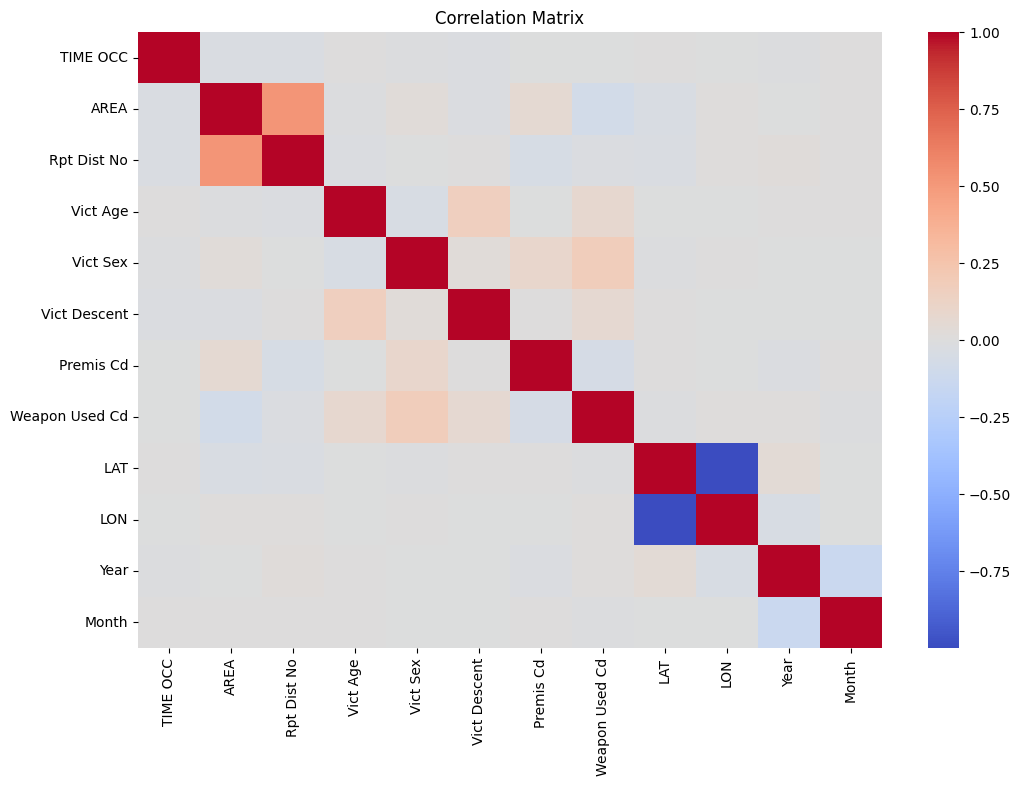

In [ ]:
# correation matrix for X




plt.figure(figsize=(12, 8))  # Adjust the width and height as needed

correlation_matrix = X.corr()

sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [57]:
#correlation between X and y

correlation_matrix = X.corrwith(y)

In [42]:
# numerical values of the correlation matrix

correlation_matrix

TIME OCC          0.020417
AREA             -0.087110
Rpt Dist No      -0.064192
Vict Age          0.010384
Vict Sex          0.192304
Vict Descent      0.019453
Premis Cd        -0.007495
Weapon Used Cd    0.459184
LAT              -0.028216
LON               0.031243
Year             -0.002133
Month            -0.005784
dtype: float64

Cross-validation scores: [0.75322874 0.75257585 0.75080081 0.75120379 0.75073451]
Mean CV score: 0.75


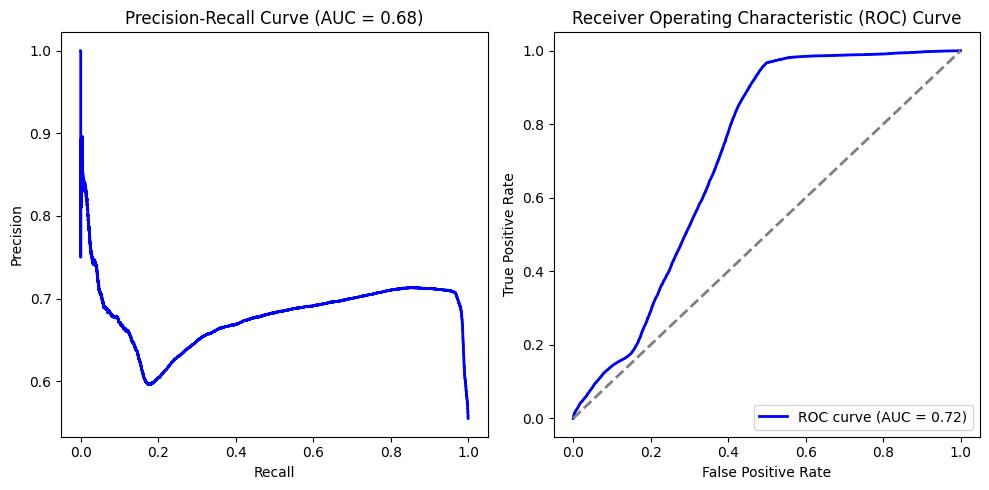

AUC-PR: 0.68
AUC-ROC: 0.72

Confusion Matrix at 0.5 threshold:
[[14408 12854]
 [ 2384 31620]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.53      0.65     27262
           1       0.71      0.93      0.81     34004

    accuracy                           0.75     61266
   macro avg       0.78      0.73      0.73     61266
weighted avg       0.78      0.75      0.74     61266



In [ ]:

#  X and y are your feature matrix and target vector
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Training
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

# Cross-validation
cv_scores = cross_val_score(log_reg, X_train, y_train, cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV score: {cv_scores.mean():.2f}")

# Calibration
calibrated_clf = CalibratedClassifierCV(log_reg, cv=5)
calibrated_clf.fit(X_train, y_train)

# Predictions with calibrated model
y_pred_proba_calibrated = calibrated_clf.predict_proba(X_test)[:, 1]

# Convert labels to 0 and 1
y_test_binary = (y_test == 2).astype(int)  # Assuming 2 is the positive class

# Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test_binary, y_pred_proba_calibrated)
pr_auc = auc(recall, precision)  # Calculate AUC for PR curve

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve (AUC = {pr_auc:.2f})')

# ROC curve
fpr, tpr, _ = roc_curve(y_test_binary, y_pred_proba_calibrated)
roc_auc = auc(fpr, tpr)

plt.subplot(122)
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

print(f"AUC-PR: {pr_auc:.2f}")
print(f"AUC-ROC: {roc_auc:.2f}")

# Print confusion matrix at 0.5 threshold
from sklearn.metrics import confusion_matrix
y_pred = (y_pred_proba_calibrated > 0.5).astype(int)
cm = confusion_matrix(y_test_binary, y_pred)
print("\nConfusion Matrix at 0.5 threshold:")
print(cm)

# Print classification report
from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(y_test_binary, y_pred))

Best parameters from Grid Search: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}
Cross-validation scores: [0.79199396 0.7908106  0.7930345  0.79425447 0.79325471]
Mean CV score: 0.79


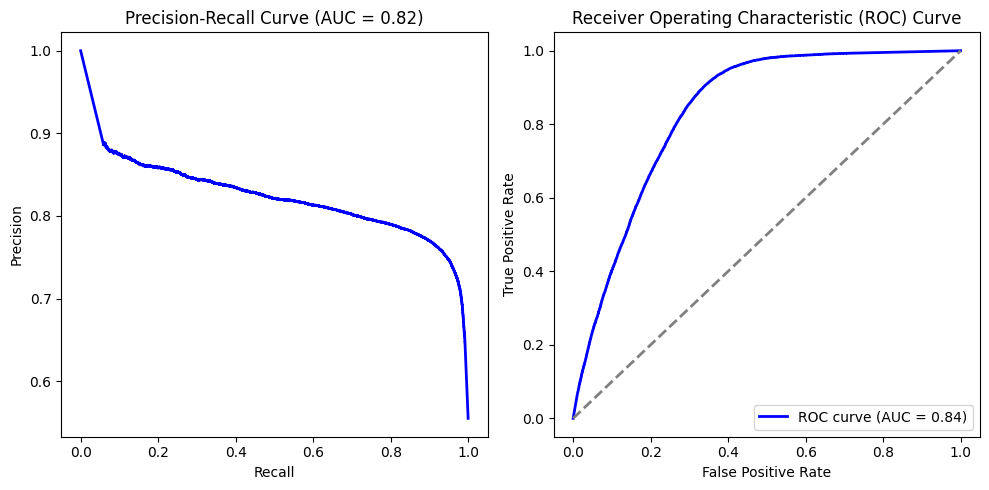

AUC-PR: 0.82
AUC-ROC: 0.84

Confusion Matrix at 0.5 threshold:
[[18283  8979]
 [ 3630 30374]]

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.67      0.74     27262
           1       0.77      0.89      0.83     34004

    accuracy                           0.79     61266
   macro avg       0.80      0.78      0.79     61266
weighted avg       0.80      0.79      0.79     61266



In [ ]:


# Assuming X and y are your feature matrix and target vector
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# KNN Model with Grid Search
param_grid = {'n_neighbors': [3, 5, 7, 9, 11], 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']}
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)

# Best KNN model
knn_best = grid_search.best_estimator_
print(f"Best parameters from Grid Search: {grid_search.best_params_}")

# Cross-validation with the best model
cv_scores = cross_val_score(knn_best, X_train, y_train, cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV score: {cv_scores.mean():.2f}")

# Calibration
calibrated_knn = CalibratedClassifierCV(knn_best, cv=5)
calibrated_knn.fit(X_train, y_train)

# Predictions with calibrated model
y_pred_proba_calibrated = calibrated_knn.predict_proba(X_test)[:, 1]

# Convert labels to 0 and 1
y_test_binary = (y_test == 2).astype(int)  # Assuming 2 is the positive class

# Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test_binary, y_pred_proba_calibrated)
pr_auc = auc(recall, precision)  # Calculate AUC for PR curve

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve (AUC = {pr_auc:.2f})')

# ROC curve
fpr, tpr, _ = roc_curve(y_test_binary, y_pred_proba_calibrated)
roc_auc = auc(fpr, tpr)

plt.subplot(122)
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

print(f"AUC-PR: {pr_auc:.2f}")
print(f"AUC-ROC: {roc_auc:.2f}")

# Print confusion matrix at 0.5 threshold
y_pred = (y_pred_proba_calibrated > 0.5).astype(int)
cm = confusion_matrix(y_test_binary, y_pred)
print("\nConfusion Matrix at 0.5 threshold:")
print(cm)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test_binary, y_pred))

In [58]:
!pip install xgboost
!pip install lightGBM


[LightGBM] [Info] Number of positive: 136014, number of negative: 109049
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1380
[LightGBM] [Info] Number of data points in the train set: 245063, number of used features: 12
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 12 dense feature groups (2.80 MB) transferred to GPU in 0.005734 secs. 0 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.555016 -> initscore=0.220960
[LightGBM] [Info] Start training from score 0.220960
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[457]	valid_0's binary_logloss: 0.420881
LightGBM Accuracy: 0.8126040544510822
LightGBM AUC Score: 0.8678480543973772
Confusion Matrix for LightGBM:
 [[18319  8943]
 [ 2538 31466]]


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [13:19:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	test-logloss:0.58119
[1]	test-logloss:0.52575
[2]	test-logloss:0.49395
[3]	test-logloss:0.47493
[4]	test-logloss:0.46233
[5]	test-logloss:0.45478
[6]	test-logloss:0.45012
[7]	test-logloss:0.44560
[8]	test-logloss:0.44286
[9]	test-logloss:0.44040
[10]	test-logloss:0.43924
[11]	test-logloss:0.43754
[12]	test-logloss:0.43616
[13]	test-logloss:0.43538
[14]	test-logloss:0.43500
[15]	test-logloss:0.43303
[16]	test-logloss:0.43274
[17]	test-logloss:0.43167
[18]	test-logloss:0.43064
[19]	test-logloss:0.43024
[20]	test-logloss:0.42999
[21]	test-logloss:0.42957
[22]	test-logloss:0.42928
[23]	test-logloss:0.42869
[24]	test-logloss:0.42810
[25]	test-logloss:0.42778
[26]	test-logloss:0.42742
[27]	test-logloss:0.42722
[28]	test-logloss:0.42682
[29]	test-logloss:0.42653
[30]	test-logloss:0.42626
[31]	test-logloss:0.42577
[32]	test-logloss:0.42549
[33]	test-logloss:0.42530
[34]	test-logloss:0.42522
[35]	test-logloss:0.42519
[36]	test-logloss:0.42502
[37]	test-logloss:0.42498
[38]	test-logloss:0.42

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [13:19:20] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Stratified Cross-Validation AUC Scores: [0.8564613  0.86240381 0.86932412 0.87377146 0.86953935]
XGBoost Accuracy: 0.8111350504358045
XGBoost AUC Score: 0.8665085914363897
Confusion Matrix for XGBoost:
 [[18423  8839]
 [ 2732 31272]]


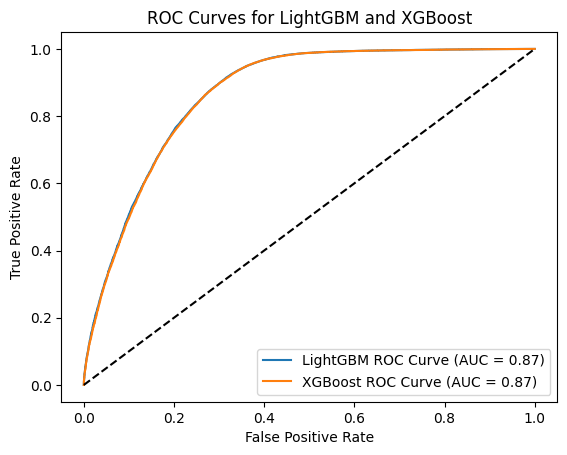

In [ ]:



# Rename columns in X to replace whitespaces (optional but avoids warnings)
X.columns = [col.replace(' ', '_') for col in X.columns]

# Convert {1, 2} labels to {0, 1} for binary classification consistency
y_binary = (y == 2).astype(int)

# Split data
X_train, X_test, y_train_binary, y_test_binary = train_test_split(X, y_binary, test_size=0.2, stratify=y_binary, random_state=42)

### LightGBM with GPU

# Prepare LightGBM dataset format
train_data_lgb = lgb.Dataset(X_train, label=y_train_binary)
test_data_lgb = lgb.Dataset(X_test, label=y_test_binary, reference=train_data_lgb)

# Set up LightGBM parameters for GPU
params_lgb = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'device': 'gpu',  # GPU setting for LightGBM
}

# Train LightGBM model with early stopping callback
model_lgb = lgb.train(
    params_lgb,
    train_data_lgb,
    num_boost_round=1000,
    valid_sets=[test_data_lgb],
    callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=True)]
)

# Make predictions
y_pred_proba_lgb = model_lgb.predict(X_test, num_iteration=model_lgb.best_iteration)
y_pred_binary_lgb = (y_pred_proba_lgb >= 0.5).astype(int)  # Predicted labels in {0, 1}

# LightGBM Evaluation
accuracy_lgb = accuracy_score(y_test_binary, y_pred_binary_lgb)
auc_lgb = roc_auc_score(y_test_binary, y_pred_proba_lgb)
print("LightGBM Accuracy:", accuracy_lgb)
print("LightGBM AUC Score:", auc_lgb)

# Confusion Matrix for LightGBM
cm_lgb = confusion_matrix(y_test_binary, y_pred_binary_lgb)
print("Confusion Matrix for LightGBM:\n", cm_lgb)

# ROC Curve for LightGBM
fpr_lgb, tpr_lgb, _ = roc_curve(y_test_binary, y_pred_proba_lgb)
roc_auc_lgb = auc(fpr_lgb, tpr_lgb)
plt.plot(fpr_lgb, tpr_lgb, label=f'LightGBM ROC Curve (AUC = {roc_auc_lgb:.2f})')

### XGBoost with GPU

# Adjusted XGBoost parameters with "device" and "tree_method" update
params_xgb = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'tree_method': 'hist',  # Use "hist" with device="cuda" for GPU
    'device': 'cuda',  # New GPU setting
    'use_label_encoder': False,
}

# Convert dataset to DMatrix format for XGBoost
dtrain_xgb = xgb.DMatrix(X_train, label=y_train_binary)
dtest_xgb = xgb.DMatrix(X_test, label=y_test_binary)

# Train XGBoost model
model_xgb = xgb.train(params_xgb, dtrain_xgb, num_boost_round=1000, evals=[(dtest_xgb, 'test')], early_stopping_rounds=50)

# Make predictions
y_pred_proba_xgb = model_xgb.predict(dtest_xgb)
y_pred_binary_xgb = (y_pred_proba_xgb >= 0.5).astype(int)  # Predicted labels in {0, 1}

# cross validation
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=5)
cv_scores_xgb = cross_val_score(xgb.XGBClassifier(**params_xgb), X, y_binary, cv=cv, scoring='roc_auc')
print("Stratified Cross-Validation AUC Scores:", cv_scores_xgb)


# XGBoost Evaluation
accuracy_xgb = accuracy_score(y_test_binary, y_pred_binary_xgb)
auc_xgb = roc_auc_score(y_test_binary, y_pred_proba_xgb)
print("XGBoost Accuracy:", accuracy_xgb)
print("XGBoost AUC Score:", auc_xgb)

# Confusion Matrix for XGBoost
cm_xgb = confusion_matrix(y_test_binary, y_pred_binary_xgb)
print("Confusion Matrix for XGBoost:\n", cm_xgb)

# ROC Curve for XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test_binary, y_pred_proba_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost ROC Curve (AUC = {roc_auc_xgb:.2f})')

# Plotting ROC Curves
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for LightGBM and XGBoost')
plt.legend(loc="lower right")
plt.show()


E0000 00:00:1731676096.198464      13 common_lib.cc:798] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:479
D1115 13:08:16.206321168      13 config.cc:196]                        gRPC EXPERIMENT call_status_override_on_cancellation   OFF (default:OFF)
D1115 13:08:16.206338112      13 config.cc:196]                        gRPC EXPERIMENT call_v3                                OFF (default:OFF)
D1115 13:08:16.206341958      13 config.cc:196]                        gRPC EXPERIMENT canary_client_privacy                  ON  (default:ON)
D1115 13:08:16.206344775      13 config.cc:196]                        gRPC EXPERIMENT capture_base_context                   ON  (default:ON)
D1115 13:08:16.206347492      13 config.cc:196]                        gRPC EXPERIMENT client_idleness                        ON  (defau

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


I0000 00:00:1731676107.337498      13 service.cc:145] XLA service 0x581046b4c660 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731676107.337552      13 service.cc:153]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1731676107.337556      13 service.cc:153]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1731676107.337559      13 service.cc:153]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1731676107.337562      13 service.cc:153]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1731676107.337565      13 service.cc:153]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1731676107.337568      13 service.cc:153]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1731676107.337571      13 service.cc:153]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1731676107.337573      13 service.cc:153]   StreamExecutor device (7): TPU, 2a886c8


INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)
I

/usr/local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1731676111.425385      13 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch 1/100


2024-11-15 13:08:36.325560: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.
I0000 00:00:1731676116.576713     927 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(574ae9ecca74eec8:0:0), session_name()


 14/192 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5393 - loss: 0.6988

I0000 00:00:1731676120.428160     927 tpu_compile_op_common.cc:245] Compilation of 574ae9ecca74eec8:0:0 with session name  took 3.851389052s and succeeded
I0000 00:00:1731676120.450231     927 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(574ae9ecca74eec8:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_15319798763326994616", property.function_library_fingerprint = 17758573410931730978, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "128,12,;128,1,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1731676120.450283     927 tpu_compilation_cache_interface.cc:541] After adding entry for key 574

185/192 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6826 - loss: 0.6010

I0000 00:00:1731676122.001047     947 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(110b69d652577b12:0:0), session_name()


192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6844 - loss: 0.5993

I0000 00:00:1731676125.731680     947 tpu_compile_op_common.cc:245] Compilation of 110b69d652577b12:0:0 with session name  took 3.73059114s and succeeded
I0000 00:00:1731676125.748825     947 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(110b69d652577b12:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_15319798763326994616", property.function_library_fingerprint = 17758573410931730978, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "59,12,;59,1,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1731676125.748865     947 tpu_compilation_cache_interface.cc:541] After adding entry for key 110b69

192/192 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step - accuracy: 0.6847 - loss: 0.5991 - val_accuracy: 0.7491 - val_loss: 0.5228
Epoch 2/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7623 - loss: 0.5203 - val_accuracy: 0.7519 - val_loss: 0.5125
Epoch 3/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7523 - loss: 0.5143 - val_accuracy: 0.7522 - val_loss: 0.5115
Epoch 4/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7607 - loss: 0.5061 - val_accuracy: 0.7542 - val_loss: 0.5099
Epoch 5/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7679 - loss: 0.4937 - val_accuracy: 0.7535 - val_loss: 0.5090
Epoch 6/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7666 - loss: 0.5031 - val_accuracy: 0.7535 - val_loss: 0.5073
Epoch 7/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7717 - loss: 0.4904 - val_accuracy: 0.7542 - val_loss: 0.5069
Epoch 8/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.7678 - loss: 0.4936 - val_accurac

2024-11-15 13:13:45.164610: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node sequential_1/dense_1/Add/ReadVariableOp.
I0000 00:00:1731676425.190989     944 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(f59ef47ee5743a93:0:0), session_name()
I0000 00:00:1731676425.255633     944 tpu_compile_op_common.cc:245] Compilation of f59ef47ee5743a93:0:0 with session name  took 64.606694ms and succeeded
I0000 00:00:1731676425.256427     944 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(f59ef47ee5743a93:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_10719069236168596214", property.function_library_fingerprint = 12807041964375402518, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, to

1915/1915 ━━━━━━━━━━━━━━━━━━━━ 56s 29ms/step


I0000 00:00:1731676480.839783     890 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(8a04d93542bd0f88:0:0), session_name()
I0000 00:00:1731676480.912737     890 tpu_compile_op_common.cc:245] Compilation of 8a04d93542bd0f88:0:0 with session name  took 72.899375ms and succeeded
I0000 00:00:1731676480.913108     890 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(8a04d93542bd0f88:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_10100689002432669739", property.function_library_fingerprint = 9171126548807461504, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "3,12,;", property.guaranteed_constants_size = 0, embedding_

ANN Model Accuracy: 0.7876962752587079
ANN Model AUC Score: 0.8402832490303889
Confusion Matrix:
 [[17076 10186]
 [ 2821 31183]]


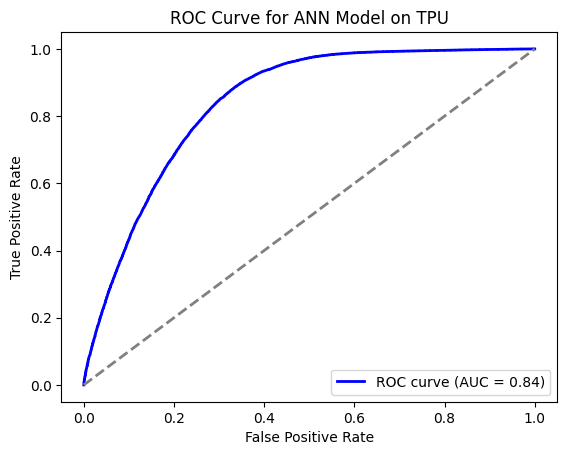

In [ ]:


# Prepare the data
# Assuming X and y are already defined with necessary preprocessing
# Convert {1, 2} labels to {0, 1} for binary classification consistency
y_binary = (y == 2).astype(int)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, stratify=y_binary, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Configure TPU
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # Detect TPU
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    tpu_strategy = tf.distribute.TPUStrategy(tpu)
    print("TPU successfully initialized")
except ValueError:
    print("TPU not found, running on CPU or GPU instead")
    tpu_strategy = tf.distribute.get_strategy()  # Default to CPU/GPU strategy

# Define the ANN model within the TPU strategy scope
with tpu_strategy.scope():
    model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')  # Sigmoid for binary classification
    ])

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

# Set early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=1024,  # Large batch size for TPU
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model on the test set
y_pred_proba = model.predict(X_test).ravel()  # Use ravel() to ensure 1D array for metrics
y_pred = (y_pred_proba >= 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred_proba)
print("ANN Model Accuracy:", accuracy)
print("ANN Model AUC Score:", auc_score)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for ANN Model on TPU')
plt.legend(loc='lower right')
plt.show()
